In [ ]:
# It is assumed that you would be running this on a CPU. 

In [1]:
!pip install torchtext==0.6.0 --quiet
!pip3 install pytorch_lightning --quiet
!pip install keybert --quiet
!pip install keytotext --quiet

In [2]:
!wget -O model_checkpoint.ckpt https://rice.box.com/shared/static/3cfbqj3a2c44esp5wadukhfwwbkjbmpu.ckpt --quiet
!wget -O vocab_obj.pth https://rice.box.com/shared/static/k648cy0rmnp5kefkg3c0zpxaq7f4qe2f.pth --quiet
!wget -O t5-base_best.bin https://rice.box.com/shared/static/xzznmo11rfuw2ncw1gbkgbjuqyrtyij4.bin --quiet

In [5]:
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
import torchtext
import pandas, os, pickle
from tqdm.notebook import tqdm
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
import requests
from io import BytesIO
import torchvision
import torchvision.transforms as transforms
from keybert import KeyBERT

textTokenizer = torchtext.data.Field(sequential = True,
                                            init_token = "<start>", eos_token = "<end>", 
                                            pad_token = "<pad>", unk_token = "<unk>",
                                            batch_first = True)

textTokenizer.vocab = torch.load("/content/vocab_obj.pth")

In [6]:
# test_set = CategoryDataset(tokenizer = textTokenizer, filenames = ["/content/train_data4.pkl"], build_vocab = False, start = 3000, end = 4000)

In [7]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.base_network.layer1(x)
            x = self.base_network.layer2(x)
            x = self.base_network.layer3(x)
            x = self.base_network.layer4(x)
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap

In [8]:
import torch.nn as nn
from torch.nn import functional as F

class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size ):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)

In [9]:
import random 
import pytorch_lightning as pl

# Image Captioning module.
# Using pytorch-lightning for simplicity.

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer.vocab)
        self.padding_token_id = textTokenizer.vocab.stoi["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, lengths = batch

        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)        

        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts, lengths = batch

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()

        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        print(outputs[0])
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []

In [10]:
# Load the pre-trained model
checkpoint = torch.load("/content/model_checkpoint.ckpt", map_location=torch.device('cpu'))
image_captioner = ImageCaptioner(textTokenizer)
image_captioner.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [11]:
# Write a function to generate captions

def generate_keywords(model, image, max_length = 15):

    # Set the starting text with just the start token
    text = "<start>"

    # We evaluate the model in order to get it started
    model.eval()

    # After initializing the transforms, we can apply them to our image
    model.init_image_transforms()
    image = model.image_test_transform(image)
    image = image[None, :]

    # Create a text_tensor which can be used for the model
    text_tensor = torch.tensor([textTokenizer.vocab.stoi["<start>"]]).unsqueeze(0);

    # Run the model and change the results to a desirable format
    predicted_scores, _ = model(image, text_tensor, [max_length], 0)
    predicted_scores = predicted_scores[0, :, :].detach().softmax(dim = 1)
    predicted_scores = predicted_scores.view(-1, model.vocabulary_size)

    # Choose the tokens with the highest prediction score
    _, max_token = predicted_scores.max(dim = 1)

    # Get started on creating a text from these tokens and stop when we hit an 
    # <end> token
    final_text = ""

    for id in max_token:
      final_text += " "
      final_text += textTokenizer.vocab.itos[id]
      if textTokenizer.vocab.itos[id] == "<end>":
        break

    return final_text

In [12]:
def get_keywords(filename):

    img = Image.open(filename)
    caption = generate_keywords(image_captioner, img)

    # print("Caption from CNN: ", caption)

    keywords = caption.split(' ')[1:-1]
    # print("Keywords: ", keywords)

    keys = []
    for word in keywords:
      if word != '<unk>' and word != 'cat':
        keys.append(word)
    # print("Keys: ", keys)

    # display_image(img)

    return keys

In [13]:
from transformers import T5ForConditionalGeneration,Adafactor,T5Tokenizer

t5_str = 't5-base'

t5_tokenizer = T5Tokenizer.from_pretrained(t5_str)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_str, return_dict=True)
t5_model.load_state_dict(torch.load('t5-base_best.bin', map_location=torch.device('cpu')))

def generate(text_list,model,tokenizer):
   text=", ".join(text_list)
   model.eval()
   input_ids = tokenizer.encode(text, 
                               return_tensors="pt")  
   outputs = model.generate(input_ids)
   replaced = tokenizer.decode(outputs[0])
   replace_pairs = [('webNLG:', ''),
                    ('WebNLG:', ''),
                    ('webNLG', '<unk>'),
                    ('WebNLG', '<unk>'),
                    ('webNG', '<unk>'),
                    ('WebNG', '<unk>'),
                    ('webng', '<unk>'),
                    ('</s>', ''),
                    ('<pad>', '')]
   for (bad, good) in replace_pairs:
     replaced = replaced.replace(bad, good)
   return replaced

In [14]:
def generate_caption(url, input_words):

    filename=BytesIO(requests.get(url).content)

    display_image(Image.open(filename))

    try: 
      cnn_keywords = get_keywords(filename)
      print("Keywords: ", cnn_keywords)
    except: 
      print("Image is invalid. Please try with a different image type.")

    combined_keywords = list(set(input_words.split(" ")+cnn_keywords))
    # combined_keywords.remove("")

    if combined_keywords == []:
      combined_keywords = ['cat']

    # print(combined_keywords)
    caption = generate(combined_keywords, t5_model, t5_tokenizer)

    return caption

In [16]:
# Plot the image.
def display_image(img):
  plt.figure(); plt.imshow(img)
  plt.grid(False);  plt.axis('off'); plt.show()

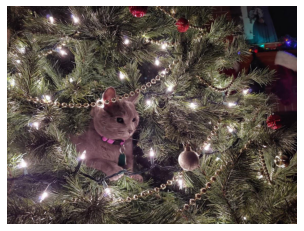

Keywords:  ['tree', 'christmas', 'ready']
Final caption:   excited about the christmas tree


In [47]:
########### EXPLORE OUR MODEL ################

# Enter a URL for any cat image on the internet
url = "https://i.redd.it/45eo4zzgw7841.jpg"

# Enter the keywords for the caption in a single string
keywords = "excited"

caption = generate_caption(url, keywords)
print("Final caption: ", caption)